# Aircraft Safety Analysis for Business Expansion

<img src="images/Flight-Safety-Instructions.jpg">

[Credit: Paxes.com](https://www.paxes.com/blog/flight-safety-instructions/)

## Business Understanding

My company has decided to expand into operating airplanes for commercial and private use. I have been tasked with examining the risks of different aircraft makes and models and making recommendations for the lowest-risk aircraft for purchase.

I will aim to identify which aircraft models present the lowest risk in terms of safety. The key questions I'm seeking to answer include:
- Which aircraft models have the lowest occurrences of severe injuries from high-damage events?
- How do factors such as the number of engines and the purpose of flight impact the safety of the aircraft?

## Data Understanding

The dataset contains records of aircraft incidents and accidents from the NTSB up to 2023, including information on the event, location, aircraft characteristics, and injury severity. The dataset has 90,348 entries and 31 columns. Some key columns include:

- `Event.Id`: Unique identifier for each event.
- `Event.Date`: Date of the event.
- `Location`: Location of the event.
- `Country`: Country where the event occurred.
- `Injury.Severity`: Severity of injuries in the event.
- `Aircraft.damage`: Extent of damage to the aircraft.
- `Make` and `Model`: Manufacturer and model of the aircraft.
- `Number.of.Engines`: Number of engines on the aircraft.
- `Purpose.of.flight`: The purpose of the flight during the event.

There are 5 numerical columns and 26 categorical columns. Examples of numerical columns include `Number.of.Engines`, `Total.Fatal.Injuries`, `Total.Serious.Injuries`, `Total.Minor.Injuries`, and `Total.Uninjured`. Examples of categorical columns include `Event.Id`, `Investigation.Type`, `Accident.Number`, `Event.Date`, and `Location`.

By following this structured approach, we will be able to gain insights into the safety of different aircraft models and provide actionable recommendations to the company's aviation division.

# Data Preparation

In this section, I will import our needed libraries for our notebook, import the data from a csv file, and begin cleaning and preparing the data for analysis using the following techniques:

1. **Handling Duplicate Values**: Identify and remove duplicate rows.
2. **Handling Unnecessary Values**: Identify and remove both columns and rows that are unnecessary to the analysis.
3. **Handling Missing Values**: Identify and handle missing values appropriately, either by imputation, placeholders, or removal.
4. **Data Type Conversion**: Convert columns to appropriate data types (e.g., dates to datetime objects, numerical columns to numeric types).
5. **Feature Engineering**: Create new features through encoding categorical values into numerical values such as `Aircraft.Damage` and extract useful information for analysis such as the month and year from `Event.Date`.

In [242]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import helper_functions

In [124]:
# Reading data from a CSV file
df = pd.read_csv('data/Aviation_Data.csv')

# Preview the data
df.head()

/var/folders/qs/svfy8y496zs3ryjhvjm063340000gn/T/ipykernel_6858/3991686835.py:2: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/Aviation_Data.csv')


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [125]:
# Get an overview of the types of data, features, and completeness of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

In [126]:
# Dropping duplicate rows
df.drop_duplicates(inplace=True)

# Resetting the index
df = df.reset_index(drop=True)

# Re-check the overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88958 entries, 0 to 88957
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88958 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

Removed 1390 duplicated rows.

In [127]:
# Function to display missing data for each column in numberical and percentage format
def percent_data_missing(df):
    # Summing the null values for each column
    missing_data_summary = df.isnull().sum().sort_values(ascending=False)
    # Converting to a percentage format
    missing_data_percentage = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    
    missing_data_df = pd.DataFrame({'Missing Values': missing_data_summary, 'Percentage': missing_data_percentage})
    # Display info to the user
    print(missing_data_df)

In [128]:
percent_data_missing(df)

                        Missing Values  Percentage
Schedule                         76376   85.856247
Air.carrier                      72310   81.285550
FAR.Description                  56935   64.002113
Aircraft.Category                56671   63.705344
Longitude                        54585   61.360417
Latitude                         54576   61.350300
Airport.Code                     38826   43.645316
Airport.Name                     36254   40.754064
Broad.phase.of.flight            27234   30.614447
Publication.Date                 15299   17.198004
Total.Serious.Injuries           12579   14.140381
Total.Minor.Injuries             12002   13.491760
Total.Fatal.Injuries             11470   12.893725
Engine.Type                       7165    8.054363
Report.Status                     6453    7.253985
Purpose.of.flight                 6261    7.038153
Number.of.Engines                 6153    6.916747
Total.Uninjured                   5981    6.723398
Weather.Condition              

`Aircraft.Category` is something I'd like to be able to filter on and there are a ton of missing values. I want to see if we can glean that information from matching values in other columns. This is a great case for a function as we can probably use it for filling in other missing values later on.

In [129]:
# Function that searches a user-specified column to fill null values on in a provided dataframe,
# and a column to reference and find correct values to change nulls into.
def fill_nan_column_with_mode(df, column_to_fill, reference_column):
    nan_indices = df[df[column_to_fill].isna()].index.tolist()
    
    # Use tqdm to create a progress bar
    for index in tqdm(nan_indices, desc=f"Filling NaN values in '{column_to_fill}'"):
        row = df.loc[index]
        ref_value = row[reference_column]
        
        # If reference value is NaN, skip this row
        if pd.isna(ref_value):
            continue
        
        # Create a temporary DataFrame with the same reference value
        temp_df = df[df[reference_column] == ref_value]
        
        # Drop rows where the column to fill is NaN
        temp_df = temp_df.dropna(subset=[column_to_fill])
        
        # If temp_df is not empty, calculate the mode
        if not temp_df.empty:
            mode_value = temp_df[column_to_fill].mode()
            
            if not mode_value.empty:
                # Fill the NaN value with the mode
                df.at[index, column_to_fill] = mode_value.iloc[0]
                
    return df

In [130]:
# Checking for Aircraft.Category values in same Model
df = fill_nan_column_with_mode(df, 'Aircraft.Category', 'Model')

Filling NaN values in 'Aircraft.Category': 100%|██████████| 56671/56671 [03:07<00:00, 302.83it/s]


That saved 48,323 data points in the `Aircraft.Category` column.

Now I want to take a look at the aircraft categories to see if there are any we should exclude

In [131]:
df['Aircraft.Category'].value_counts()

Aircraft.Category
Airplane             70768
Helicopter            7646
Glider                 989
Balloon                470
Gyrocraft              266
Weight-Shift           165
Powered Parachute       95
Ultralight              33
Unknown                 15
WSFT                     9
Blimp                    7
Powered-Lift             6
UNK                      2
Rocket                   1
ULTR                     1
Name: count, dtype: int64

In [132]:
# For now, I'm only wanting to keep Aircraft.Category values of 'Airplane', and 'Helicopter'
aircraft_cats_to_keep = ['Airplane', 'Helicopter']

df = df[df['Aircraft.Category'].isin(aircraft_cats_to_keep)]

In [133]:
# `Schedule`, `Air.Carrier`, `FAR.Description`, `Latitude`, and `Longitude` all have missing data from over 60% of the rows.
# `Registration.Number`, `Airport.Name`, `Airport.Code`, and `Report.Status` cannot be imputed and is not helpful to the analysis.
# Dropping those columns
df.drop(columns=['Schedule', 'Air.carrier', 'FAR.Description', 'Latitude', 'Longitude', 'Registration.Number', 'Airport.Name', 'Airport.Code', 'Report.Status'], inplace=True)

In [134]:
# Dropping rows with <1% of missing values

# Attempting to impute Make from Model
df = fill_nan_column_with_mode(df, 'Model', 'Make')

# Dropping remaining rows with <1% missing values
df.dropna(subset=['Event.Id', 'Accident.Number', 'Event.Date', 'Location', 'Amateur.Built', 'Country', 'Make', 'Model'], inplace=True)

Filling NaN values in 'Model': 100%|██████████| 33/33 [00:00<00:00, 295.24it/s]


In [135]:
# Investigating makeup of amateur built aircraft
df['Amateur.Built'].value_counts()

Amateur.Built
No     72394
Yes     5692
Name: count, dtype: int64

In [136]:
# Dropping all amateur built aircraft
df = df[df['Amateur.Built'] != 'Yes']
# Dropping the `Amateur.Built` column
df.drop(columns=['Amateur.Built'], inplace=True)

`Injury.Severity` might be something that could help us with our safety determinations:

In [137]:
# Investigating `Injury.Severity`
df['Injury.Severity'].unique()

array(['Fatal(2)', 'Fatal(3)', 'Fatal(1)', 'Non-Fatal', 'Fatal(4)',
       'Incident', 'Fatal(8)', 'Fatal(78)', 'Fatal(7)', 'Fatal(6)',
       'Fatal(5)', 'Fatal(12)', 'Fatal(14)', 'Fatal(10)', 'Fatal(11)',
       'Fatal(17)', 'Fatal(13)', 'Fatal(29)', 'Fatal(9)', 'Unavailable',
       'Fatal(135)', 'Fatal(25)', 'Fatal(82)', 'Fatal(156)', 'Fatal(18)',
       'Fatal(144)', 'Fatal(111)', 'Fatal(20)', 'Fatal(73)', 'Fatal(27)',
       'Fatal(34)', 'Fatal(87)', 'Fatal(16)', 'Fatal(56)', 'Fatal(37)',
       'Fatal(54)', 'Fatal(65)', 'Fatal(160)', 'Fatal(189)', 'Fatal(97)',
       'Fatal(125)', 'Fatal(228)', 'Fatal(52)', 'Fatal(15)', 'Fatal(229)',
       'Fatal(80)', 'Fatal(169)', 'Fatal(88)', 'Fatal(131)', 'Fatal(60)',
       'Fatal(143)', 'Fatal(83)', 'Fatal(24)', 'Fatal(44)', 'Fatal(64)',
       'Fatal(92)', 'Fatal(19)', 'Fatal(26)', 'Fatal(138)', 'Fatal(206)',
       'Fatal(71)', 'Fatal(23)', 'Fatal(21)', 'Fatal(115)', 'Fatal(141)',
       'Fatal(121)', 'Fatal(45)', 'Fatal(145)', 'Fatal(1

There are a lot of different variations of "Fatal" in this column. All with numbers in parenthesis following the value. Let's compare these to a sample of the `Total.Fatal.Injuries` column.

In [138]:
# Comparing `Injury.Severity` column to `Total.Fatal.Injuries` column
df[df['Injury.Severity'] == 'Fatal(2)']['Total.Fatal.Injuries']

0        2.0
3        2.0
15       2.0
24       2.0
33       2.0
        ... 
63822    2.0
63823    2.0
63826    2.0
63828    2.0
63874    2.0
Name: Total.Fatal.Injuries, Length: 2972, dtype: float64

In [139]:
# Unique values of `Injury.Severity` appear to be duplicated in other columns.
# Dropping `Injury.Severity` column.
df.drop(columns=['Injury.Severity'], inplace=True)

In [140]:
# There are two 'date' columns and I am only interested in the date of the event.
# Dropping `Publication.Date` column
df.drop(columns=['Publication.Date'], inplace=True)

In [141]:
# Converting `Event.Date` into a datetime object
df['Event.Date'] = pd.to_datetime(df['Event.Date'])

In [142]:
# Moving onto `Weather.Conditions`
df['Weather.Condition'].unique()

array(['UNK', 'IMC', 'VMC', nan, 'Unk'], dtype=object)

In [143]:
# Filling null values with 'UNK'
df['Weather.Condition'] = df['Weather.Condition'].fillna('UNK')

In [144]:
# Function to rename column values (case insensitive)
def rename_value(df, col_name, old_value, new_value):
    # Setting old value to new value
    df.loc[df[col_name].str.lower().str.contains(old_value.lower()), col_name] = new_value

rename_value(df, 'Weather.Condition', 'Unk', 'UNK')

df['Weather.Condition'].unique()

array(['UNK', 'IMC', 'VMC'], dtype=object)

In [145]:
# Investigating the `Broad.phase.of.flight` column
df['Broad.phase.of.flight'].unique()

array(['Cruise', 'Approach', 'Climb', 'Unknown', 'Takeoff', 'Landing',
       'Taxi', 'Descent', 'Maneuvering', 'Standing', 'Go-around', 'Other',
       nan], dtype=object)

In [146]:
# Filling null values with 'Unknown'
df['Broad.phase.of.flight'] = df['Broad.phase.of.flight'].fillna('Unknown')

In [147]:
# Investigating `Purpose.of.flight` column
df['Purpose.of.flight'].unique()

array(['Personal', nan, 'Business', 'Instructional', 'Unknown', 'Ferry',
       'Executive/corporate', 'Aerial Observation', 'Aerial Application',
       'Public Aircraft', 'Skydiving', 'Other Work Use', 'Positioning',
       'Flight Test', 'Air Race/show', 'Air Drop',
       'Public Aircraft - Federal', 'Glider Tow',
       'Public Aircraft - Local', 'External Load',
       'Public Aircraft - State', 'Banner Tow', 'Firefighting',
       'Air Race show', 'PUBS', 'ASHO', 'PUBL'], dtype=object)

In [148]:
# Filling null values with 'Unknown'
df['Purpose.of.flight'] = df['Purpose.of.flight'].fillna('Unknown')

In [149]:
# There are some flight types in here that likely don't apply to our business case so let's drop them
# List of flight types to drop
flight_types_to_drop = ['Air Drop', 'Air Race/show', 'Firefighting', 'Glider Tow', 'Air Race show', 'Flight Test']

# Drop the unwanted flight types
df = df[~df['Purpose.of.flight'].isin(flight_types_to_drop)]

In [150]:
# Attempting to fill missing `Number.of.Engines` values with other `Model` matches then dropping the remaining null values.
df = fill_nan_column_with_mode(df, 'Number.of.Engines', 'Model')

df = df.dropna(subset=['Number.of.Engines'])

Filling NaN values in 'Number.of.Engines': 100%|██████████| 4404/4404 [00:12<00:00, 362.07it/s]


In [151]:
# Attempting to fill missing `Engine.Type` values with other `Model` matches then filling null values with 'UNK'
df = fill_nan_column_with_mode(df, 'Engine.Type', 'Model')

df['Engine.Type'] = df['Engine.Type'].fillna('UNK')

Filling NaN values in 'Engine.Type': 100%|██████████| 5219/5219 [00:14<00:00, 359.78it/s]


In [152]:
# Filling null `Aircraft.Damage` values with 'Unknown`
df['Aircraft.damage'] = df['Aircraft.damage'].fillna('Unknown')

In [153]:
# I want to see how many rows have zero values for all injury and uninjured columns
# Specify the columns to check
columns_to_check = ['Total.Uninjured', 'Total.Minor.Injuries', 'Total.Serious.Injuries', 'Total.Fatal.Injuries']

# Count rows where all specified columns are NaN
num_rows_all_nan = df[columns_to_check].isna().all(axis=1).sum()

print(f"Number of rows with NaN in all specified columns: {num_rows_all_nan}")

Number of rows with NaN in all specified columns: 116


In [154]:
# There aren't many rows that meet this criteria so I will drop them
# Identify rows where all specified columns are NaN
rows_to_drop = df[columns_to_check].isna().all(axis=1)

# Drop those rows
df = df.drop(index=df[rows_to_drop].index)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

In [155]:
# Filling the missing values in the 'injury' columns with 0
columns_to_fill = ['Total.Uninjured', 'Total.Minor.Injuries', 'Total.Serious.Injuries', 'Total.Fatal.Injuries']

for col in columns_to_fill:
    df[col] = df[col].fillna(0)

In [156]:
# Investigating the `Country` values
df['Country'].value_counts()

Country
United States               66323
Brazil                        332
Mexico                        306
Canada                        286
United Kingdom                262
                            ...  
French Guiana                   1
Chad                            1
Cayenne                         1
Yemen                           1
Turks and Caicos Islands        1
Name: count, Length: 204, dtype: int64

In [157]:
# Vast majority of incidents are in North America so I'll drop everything else
# List of flight types to drop
countries_to_keep = ['Canada', 'United States', 'Mexico']

# Drop the unwanted flight types
df = df[df['Country'].isin(countries_to_keep)]

In [158]:
percent_data_missing(df)

                        Missing Values  Percentage
Event.Id                             0         0.0
Number.of.Engines                    0         0.0
Weather.Condition                    0         0.0
Total.Uninjured                      0         0.0
Total.Minor.Injuries                 0         0.0
Total.Serious.Injuries               0         0.0
Total.Fatal.Injuries                 0         0.0
Purpose.of.flight                    0         0.0
Engine.Type                          0         0.0
Model                                0         0.0
Investigation.Type                   0         0.0
Make                                 0         0.0
Aircraft.Category                    0         0.0
Aircraft.damage                      0         0.0
Country                              0         0.0
Location                             0         0.0
Event.Date                           0         0.0
Accident.Number                      0         0.0
Broad.phase.of.flight          

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66915 entries, 0 to 71449
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Event.Id                66915 non-null  object        
 1   Investigation.Type      66915 non-null  object        
 2   Accident.Number         66915 non-null  object        
 3   Event.Date              66915 non-null  datetime64[ns]
 4   Location                66915 non-null  object        
 5   Country                 66915 non-null  object        
 6   Aircraft.damage         66915 non-null  object        
 7   Aircraft.Category       66915 non-null  object        
 8   Make                    66915 non-null  object        
 9   Model                   66915 non-null  object        
 10  Number.of.Engines       66915 non-null  float64       
 11  Engine.Type             66915 non-null  object        
 12  Purpose.of.flight       66915 non-null  object     

## Feature Engineering

In [162]:
# Create a total passengers column
df['Total.Pax'] = df['Total.Uninjured'] + df['Total.Minor.Injuries'] + df ['Total.Serious.Injuries'] + df['Total.Fatal.Injuries']

In [163]:
# Create a year column
df['Event.Year'] = df['Event.Date'].dt.year

In [177]:
# Private, Commercial, or Helicopter (Both)?

private_craft = ['Bombardier', 'Beechcraft', 'Cessna', 'Dassault', 'Gulfstream', 'Pilatus']
commercial_craft = ['Boeing', 'Airbus']

def determine_market(row):
    if row['Aircraft.Category'] == 'Helicopter':
        return 'Helicopter'
    elif row['Make'] in private_craft:
        return 'General Aviation'
    elif row['Make'] in commercial_craft:
        return 'Commercial Aviation'
    else:
        return 'Other'

# Apply the function to create the 'Market' column
df['Market'] = df.apply(determine_market, axis=1)

In [200]:
df['Fatality.Rate'] = df['Total.Fatal.Injuries'] / df['Total.Pax'] * 100

In [187]:
# Encode damage severity
def damage_encode(row):
    if row['Aircraft.damage'] == 'Minor':
        return 1
    elif row['Aircraft.damage'] == 'Substantial':
        return 2
    elif row['Aircraft.damage'] == 'Destroyed':
        return 3
    else:
        return 0
    
    
df['Damage.Encoded'] = df.apply(damage_encode, axis=1)

# Data Analysis

1. **Summary Statistics**: Generate summary statistics for numerical and categorical columns.
2. **Visualizations**: Create histograms, bar plots, and scatter plots to understand the distribution and relationships in the data.
   - **Average Injury Score by Model**: Identify aircraft models with the lowest average injury scores.
   - **Average Injury Score by Number of Engines**: Investigate how the number of engines impacts the injury score.
   - **Average Injury Score by Purpose of Flight**: Explore the impact of flight purpose on safety.
   - **Events by Year**: Visualize temporal trends in the number of incidents.

In [188]:
df.describe()

,Event.Date,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Total.Pax,Event.Year,Fatality.Rate,Damage.Encoded
count,66909,66909.000000,66909.000000,66909.000000,66909.000000,66909.000000,66909.000000,66909.000000,66720.000000,66909.000000
mean,1998-12-20 18:09:32.371429888,1.147454,0.366528,0.215233,0.278632,3.839588,4.699981,1998.466021,0.158083,2.126949
min,1982-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1982.000000,0.000000,0.000000
25%,1988-05-28 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1988.000000,0.000000,2.000000
50%,1997-06-13 00:00:00,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1997.000000,0.000000,2.000000
75%,2008-07-06 00:00:00,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2008.000000,0.000000,2.000000
max,2022-12-29 00:00:00,4.000000,229.000000,137.000000,125.000000,588.000000,588.000000,2022.000000,1.000000,3.000000
std,NaN,0.386159,2.008759,1.147330,1.172642,21.731229,22.024990,11.825133,0.354366,0.534426


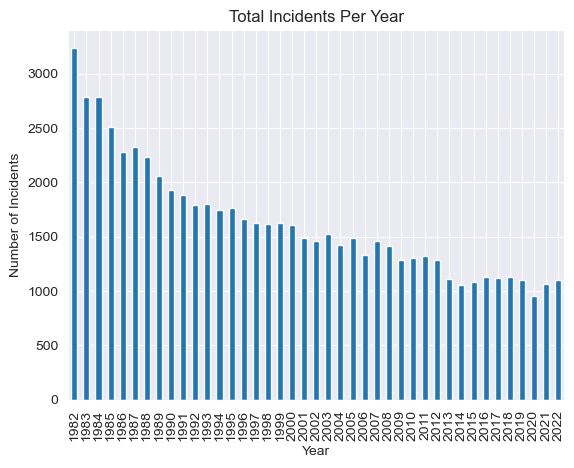

In [189]:
# How is the data spread over time?

yearly_data = df['Event.Year'].value_counts().sort_index()

fig, ax = plt.subplots()

yearly_data.plot(kind='bar', ax=ax)

ax.set_title("Total Incidents Per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Incidents")

plt.show()

In [190]:
# Virtually no data prior to 1982, we'll set our range to that.
df = df[df['Event.Year'] >= 1982]

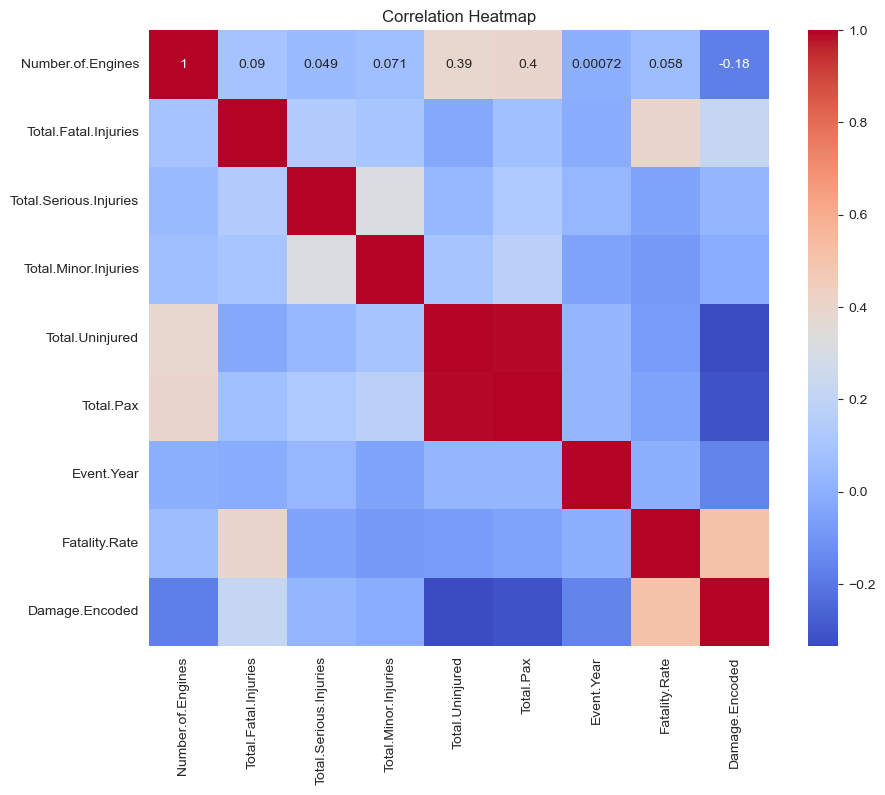

In [191]:
# Assuming df is your existing DataFrame with numeric columns
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate the correlation matrix and plot the heatmap
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', ax=ax).set_title("Correlation Heatmap")

# Show the plot
plt.show()

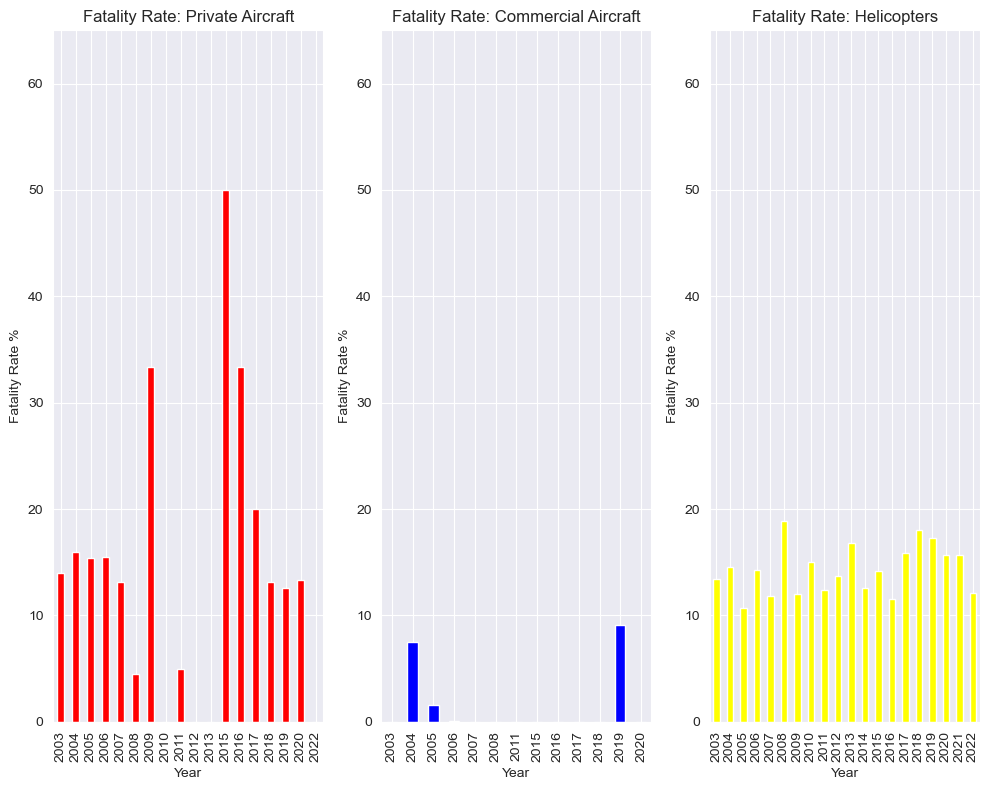

In [204]:
# Grouping the last 10 years of commercial, private, and helicopter data
df_private = df[(df['Market'] == 'General Aviation') & (df['Event.Year'] >= 2003)]
df_commercial = df[(df['Market'] == 'Commercial Aviation') & (df['Event.Year'] >= 2003)]
df_helicopter = df[(df['Market'] == 'Helicopter') & (df['Event.Year'] >= 2003)]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 8))

df_private.groupby('Event.Year')['Fatality.Rate'].agg('mean').plot(
    kind='bar',
    ax=ax1,
    title="Fatality Rate: Private Aircraft",
    color='Red',
    xlabel="Year",
    ylabel="Fatality Rate %"
)

df_commercial.groupby('Event.Year')['Fatality.Rate'].agg('mean').plot(
    kind='bar',
    ax=ax2,
    title="Fatality Rate: Commercial Aircraft",
    color='Blue',
    xlabel="Year",
    ylabel="Fatality Rate %"
)

df_helicopter.groupby('Event.Year')['Fatality.Rate'].agg('mean').plot(
    kind='bar',
    ax=ax3,
    title="Fatality Rate: Helicopters",
    color='Yellow',
    xlabel="Year",
    ylabel="Fatality Rate %"
)

ax1.set_ylim([0, 65])
ax2.set_ylim([0, 65])
ax3.set_ylim([0, 65])

plt.tight_layout()

[According to Assets America, the top commercial aircraft manufacturers are:](https://assetsamerica.com/aircraft-manufacturers/)
- Boeing (7X7 series)
- Airbus (A2XX, A3XX series)
- Embraer (ERJ, E-Jet, E-Jet E2)
- Bombardier (Q400)
- Several other Russian, East Asian, and African owned companies with no service in North America

The top private aircraft manufacturers are:
- Airbus (ACJ200, ACJ300 series)
- Boeing (BBJ 7X7 series)
- Bombardier (Learjet, Challenger, Global series)
- Beechcraft (Bonanza, Baron, King Air, T6 series)
- Cessna (Citation, Denali, Caravan, Grand Caravan, SkyCourier, Skyhawk, Skylane, Stationair)
- Dassault (Falcon, Breguet, hirondelle, Communaute)
- Embraer (Legacy, Praetor, Lineage, Phenom)
- Gulfstream (G280, G500, G550, G600, G650)
- Pilatus (PC-24, PC-12, PC-6)
- Hawker (4000)

[According to General Aviation News, the top helicopter manufacturers are:](https://generalaviationnews.com/2023/03/16/top-10-best-selling-rotorcraft-in-2022/)
- Airbus (H125, H130, H135, H145)
- Bell (407, 429, 505)
- Cabri (G2)
- Robinson (R66, R44)

[According to Assets America, the top 10 commercial aircraft manufacturers are:](https://assetsamerica.com/aircraft-manufacturers/)
- Boeing 
- Airbus
- Embraer
- Bombardier
- Comac (Russian company not operated in NA)
- Mitsubishi
- UAC (Russian company not operated in NA)
- Aviastar-SP (Russian company not operated in NA)
- Kazan Aircraft Production Association (Russian company not operated in NA)
- GippsAero (Australian company not operated in NA)

The top 10 private aircraft manufacturers are:
- Airbus Corporate Jets
- Boeing Business Jet
- Bombardier Business Aircraft
- Beechcraft
- Cessna
- Dassault Aviation
- Embraer
- Gulfstream Aerospace
- Pilatus Business Aircraft
- Hawker

[According to General Aviation News, the top helicopter manufacturers are:](https://generalaviationnews.com/2023/03/16/top-10-best-selling-rotorcraft-in-2022/)
- Airbus (H125, H130, H135, H145)
- Bell (407, 429, 505)
- Cabri (G2)
- Robinson (R66, R44)

In [210]:
df['Model'][df['Make'] == 'Boeing'].value_counts()

Model
A75N1      95
737-300    36
737        34
727-200    33
737-200    29
           ..
757-2B7     1
767-323     1
369D        1
PT17        1
B17         1
Name: count, Length: 131, dtype: int64

In [237]:
df_copy = df.copy()

In [243]:
# Apply the function to the 'Model' column where 'Make' is 'Boeing'
df_copy['model.formatted'] = df_copy.apply(lambda row: helper_functions.update_boeing_model(row['Model']) if row['Make'] == 'Boeing' else '', axis=1)

In [244]:
df_copy['model.formatted'][df['Make'] == 'Boeing'].unique()

array(['A75', '737', '727', '707', 'KC-135A', 'E75', 'E75N1', 'B75',
       '75A', 'B-75', 'N2S-1-A-75A', 'PT-17', '747', 'D75N1', '767', '75',
       'PT 17', '757', 'EC-135', 'B-17G', 'N2S-3', 'DHC-6-300', 'A 75N1',
       'A-75N1', 'DHC-8-102', '234', 'CH-47D', '369E', 'MD-11', '777',
       'DC-9-82', '369D', 'PT17', '717', 'MD-82', 'MD-11F', 'MD-10-10F',
       '1942', '787', 'B17'], dtype=object)

In [245]:
# Apply the function to the 'Model' column where 'Make' is 'Boeing'
df_copy['model.formatted'] = df_copy.apply(lambda row: helper_functions.update_airbus_model(row['Model']) if row['Make'] == 'Airbus' else '', axis=1)

In [228]:
df_copy['model.formatted'][df['Make'] == 'Airbus'].unique()

array(['A320', 'A321', 'A319', 'A330'], dtype=object)

In [229]:
df_copy['Model'][df['Make'] == 'Embraer'].unique()

array(['EMB-110P1', 'EMB-11OP1', 'EMB-110', 'EMB-120', '120', 'EMB-120ER',
       'EMB-135', 'EMB-135LR', 'EMB-145', 'EMB-145LR', 'EMB-135KL',
       'EMB-135BJ', '170', '110P1', 'EMB-170', 'EMB-190', '145', 'EMB120',
       'EMB145', 'ERJ170', 'EMB 135KL', 'ERJ190', 'ERJ170-200LR'],
      dtype=object)

In [231]:
# Apply the function to the 'Model' column where 'Make' is 'Boeing'
df_copy['model.formatted'] = df_copy.apply(lambda row: helper_functions.update_embraer_commercial_model(row['Model']) if row['Make'] == 'Embraer' else '', axis=1)

In [232]:
df_copy['model.formatted'][df['Make'] == 'Embraer'].unique()

array(['EMB-110P1', 'EMB-11OP1', 'EMB-110', 'EMB-120', '120', 'EMB-120ER',
       'EMB-135', 'EMB-135LR', 'EMB-145', 'EMB-145LR', 'EMB-135KL',
       'EMB-135BJ', 'ERJ-170', '110P1', 'ERJ-190', '145', 'EMB120',
       'EMB145', 'EMB 135KL'], dtype=object)

In [233]:
df_copy['Model'][df['Make'] == 'Mitsubishi'].unique()

array(['MU2B-40', 'MU-2B-30', 'MU-2B', 'MU-2B-25', 'MU-2B-20', 'MU-2B-60',
       'MU-2', 'MU-2B-36', 'MU-2B-35', '300', 'MU-2B-26A', 'MU2B',
       'MU 2B-40'], dtype=object)

In [234]:
# Apply the function to the 'Model' column where 'Make' is 'Boeing'
df_copy['model.formatted'] = df_copy.apply(lambda row: helper_functions.update_mitsubishi_model(row['Model']) if row['Make'] == 'Boeing' else '', axis=1)

In [236]:
df_copy['model.formatted'][df['Make'] == 'Mitsubishi'].value_counts()

Model
Marquise     28
MU-2J        14
MU-2F         9
MU-2B         8
MU-2L         8
MU-2K         7
MU-2G         5
MU-2M         4
Solitaire     2
MU-2          2
MU2B          2
300           1
Name: count, dtype: int64